<a href="https://colab.research.google.com/github/arps1214p/safeai/blob/main/default_resnet_early_stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 Import 및 환경 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124
Pillow Version:  11.2.1
CUDA is available!  Training on GPU ...


# 데이터 가져오기

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)

train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/')

Path to dataset files: /kaggle/input/the-simpsons-characters-dataset


# 함수 및 클래스 정의

## Train-val split 및 testset 가져오기

In [ ]:
class TrainValTestSplit():

  def __init__(self, train_dir, test_dir):

    self.train_dir = train_dir
    self.test_dir = test_dir
    # 하위 디렉토리를 순회하며 이미지의 경로를 리스트로 저장
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):

    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels, random_state = 42)

    train_val_files_path = {'train': train_files_path, 'val': val_files_path}

    return train_val_files_path, self.test_path

  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))


In [ ]:
TrainValTestPath = TrainValTestSplit(train_dir, test_dir)
train_path, test_path = TrainValTestPath.get_path()

## 모델 학습 함수

In [ ]:
# 조기종료 함수
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, dataloaders, cost, optimizer, save_best_weights_path, save_last_weights_path, best_acc, num_epochs=25, is_inception=False, early_stopping=None):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    lr_find_lr = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # train과 val 단계에 따라 model 모드 변경
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # train 모드라면 hitstory 저장
                with torch.set_grad_enabled(phase == 'train'):
                    # inception module을 사용하는 모델인경우 loss 설정
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = cost(outputs, labels)
                        loss2 = cost(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = cost(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimizer + scheduler
                    # scheduler의 경우 일단 비활성화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                        #lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
                        #lr_find_lr.append(lr_step)

                # 현재 에포크의 손실 저장
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # loss, acc 계산
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 현재 epoch의 정확도가 best_acc 보다 큰 경우 best 모델을 변경
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # 현재 epoch의 정확도를 history에 저장
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()
        if early_stopping is not None:
            early_stopping(val_loss_history[-1], model)
            if early_stopping.early_stop: # 조건 만족 시 조기 종료
                break

    # 학습시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # best model 로드
    model.load_state_dict(best_model_wts)

    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    history_train = {'loss': train_loss_history, 'acc': train_acc_history}

    return model, history_val, history_train, time_elapsed, lr_find_lr, best_acc

## transfer learning 시 동작 설정 함수

In [ ]:
# feature_extracting이 설정된 경우 fc레이어의 param만 학습
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## torch.models로부터 모델을 불러오는 함수

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):

    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # pretrained=true일때
        # feature_extract=true인 경우 마지막 fc레이어의 param만 학습
        set_parameter_requires_grad(model_ft, feature_extract)
        # fc레이어의 input 개수 로드
        num_ftrs = model_ft.fc.in_features
        # fc레이어의 output 개수 설정
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == 'resnet18':
        """ ResNet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# 데이터셋 클래스 생성

In [ ]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms

      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx])
      image = Image.open(img_path)
      image = self.transform(image)

      if 'test' in str(self.files_path[0]):
        return image
      else:
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()

        return image, label

# 모델 설정

In [ ]:
model_name = 'resnet18'

num_classes = TrainValTestPath.get_n_classes()
batch_size = 32
num_epochs = 2

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# pretrained 모델을 이용하는 경우
# feature_extract = False - 전체 모델 학습
# feature_extract = True - Fc 레이어만 학습
feature_extract = False

save_last_weights_path = '/kaggle/working/' + model_name + '-' + '_last_weights.pth'
save_best_weights_path = '/kaggle/working/' + model_name + '-' + '_best_weights.pth'

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

model_ft = model_ft.to(device)

# 데이터 Augmentation

In [ ]:
# ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) -> imagenet 데이터셋의 통계 기반
# TODO
# simpson 데이터셋 전체의 std와 mean 계산 후 정규화에 이용

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.RandomChoice( [
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 모델에 전달될 데이터 설정

### Dataset

In [ ]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])

### Dataloader

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

num_workers = 4
dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True,
                                                         num_workers=num_workers, worker_init_fn=seed_worker,generator=g),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True,
                                                       num_workers=num_workers,worker_init_fn=seed_worker,generator=g)}
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size, shuffle=False,
                                              num_workers=num_workers, worker_init_fn=seed_worker,generator=g)

### 이미지 출력

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

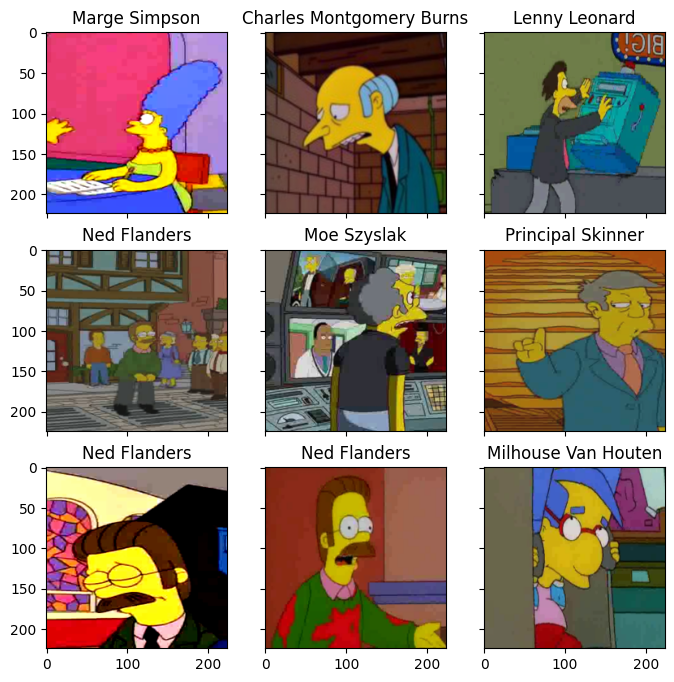

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 4500))
    im_val, label = image_datasets['train'][random_characters]
    # 캐릭터 이름 출력
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# 파라미터 설정

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            #print("\t",name)

Params to learn:


# 학습

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)
model_ft = model_ft.to(device)

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            #print("\t",name)

Params to learn:


In [ ]:
#base_lr = 0.0012
#max_lr = 0.0022
num_epoch = 30

cost = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, nesterov = True)
#step_size = 2 * math.ceil( len(dataloaders_dict['train']) / batch_size )
#scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [ ]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
lr_cycle = []
best_acc = .0

In [ ]:
es = EarlyStopping(patience = 3, verbose = True, delta = 0.005)

image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}

dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0,
                                                    worker_init_fn=seed_worker,generator=g),
                  'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=0,
                                                    worker_init_fn=seed_worker,generator=g)}

model, history_val, history_train, time_elapsed, lr_find_lr, best_acc = train_model(model_ft, dataloaders_dict, cost, optimizer_ft, save_best_weights_path, save_last_weights_path, best_acc = best_acc, num_epochs=num_epoch, is_inception=(model_name=="inception"), early_stopping = es)

val_loss += history_val['loss']
val_acc += history_val['acc']
train_loss += history_train['loss']
train_acc += history_train['acc']
lr_cycle += lr_find_lr

Epoch 1/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

# 학습 결과 및 모델 분석

## 학습 결과 시각화 함수

In [ ]:
def visualization(train, val, is_loss = True):
  if is_loss:
    plt.figure(figsize=(9,5))
    plt.plot(torch.tensor(train, device =  'cpu'), label = 'Training loss')
    plt.plot(torch.tensor(val, device =  'cpu'), label = 'Val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  else:
    plt.figure(figsize=(9,5))
    plt.plot(torch.tensor(train, device =  'cpu'), label = 'Training acc')
    plt.plot(torch.tensor(val, device =  'cpu'), label = 'Val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

## confusion_matrix for val data

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

In [ ]:
# confusion_matrix
actual = [image_datasets['val'][i][1] for i in range( len(image_datasets['val']) ) ]
image = [image_datasets['val'][i][0] for i in range( len(image_datasets['val']) ) ]
img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=batch_size, shuffle=False, num_workers=4,
                                                 worker_init_fn=seed_worker,generator=g)
probs = predict(model_ft, img_conf_dataloader)
preds = np.argmax(probs, axis=1)

df = pd.DataFrame({'actual': actual, 'preds': preds})
confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
yticklabels = label_encoder.classes_
plt.subplots(figsize=(20,20))
sn.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = label_encoder.classes_[np.unique(preds)]);

## lr_cycle, acc, loss 시각화

In [ ]:
#plt.figure(figsize=(17,10))
#plt.plot(lr_cycle);

In [ ]:
visualization(train_acc, val_acc, is_loss = False)
print('\n')
visualization(train_loss, val_loss, is_loss = True)

# 모델 테스트

## 샘플 테스트

In [ ]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

## 테스트 샘플 시각화

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = image_datasets['val'][random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((1, 189), 120, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))ь
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} :\n {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 189, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# 테스트셋에 대한 평가 지표

In [ ]:
probs = predict(model_ft, dataloader_test)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1 ))
test_file_names = [path.name for path in image_                     datasets_test.files_path]

for i in range(len(test_file_names)):
  test_file_names[i] = test_file_names[i].split('.')[0].rsplit('_', 1)[0]

present_labels = np.unique(test_file_names)

from sklearn.metrics import classification_report
print(classification_report(test_file_names, preds, labels=present_labels))

In [ ]:
#for i in range(len(test_file_names)):
#    print(test_file_names[i])

In [ ]:
#my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
#my_submit.head()
#my_submit.to_csv('simspsons.csv', index=False)